In [652]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import img_as_ubyte
%matplotlib inline

In [653]:
cx = 9
cy = 6
objp = np.zeros((cx * cy, 3), np.float32)
objp[:,:2] = np.mgrid[0:cx, 0:cy].T.reshape(-1, 2)


## Load images & draw chess board corners

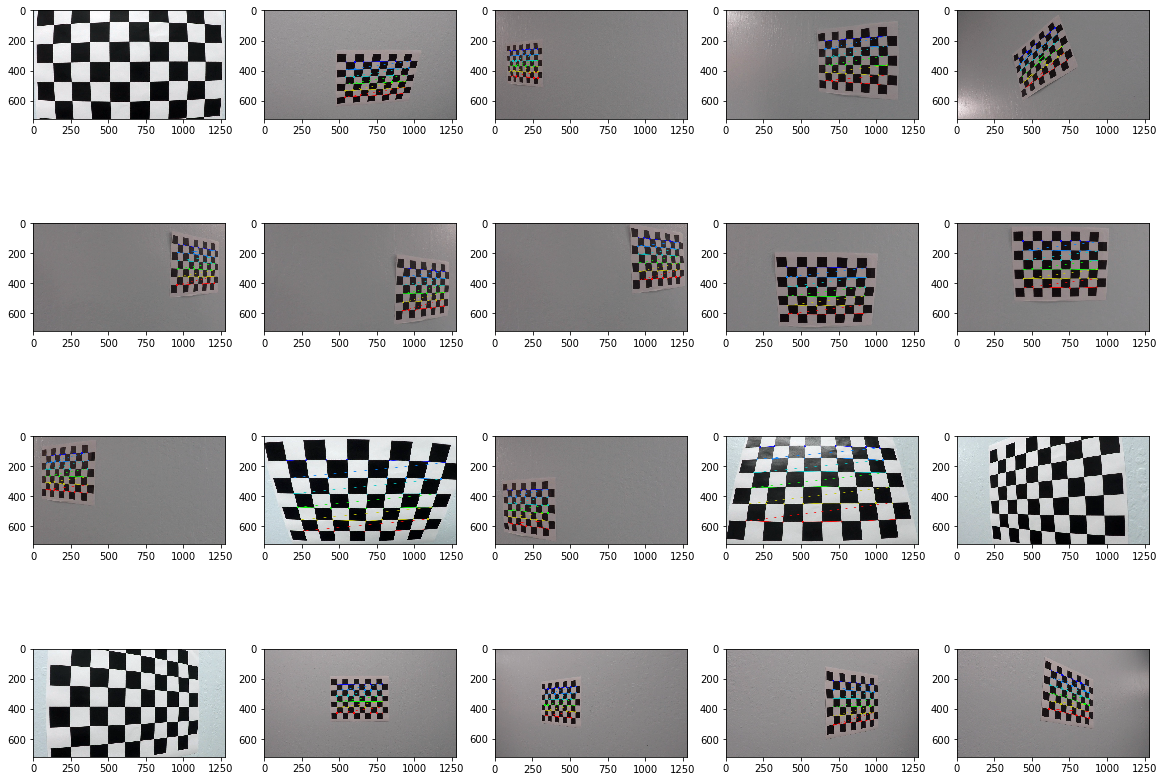

In [654]:
images = glob.glob('camera_cal/calibration*.jpg')
count = 1
fig = plt.figure(figsize=(20, 15))
mtx = []
dist = []
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

for img_dir in images:
    img = cv2.imread(img_dir)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (cx,cy), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (cx,cy), corners, ret)
    fig.add_subplot(4,5,count)
    count += 1
    plt.imshow(img)


## Calibrate Camera & Undistort -- on Chess Board

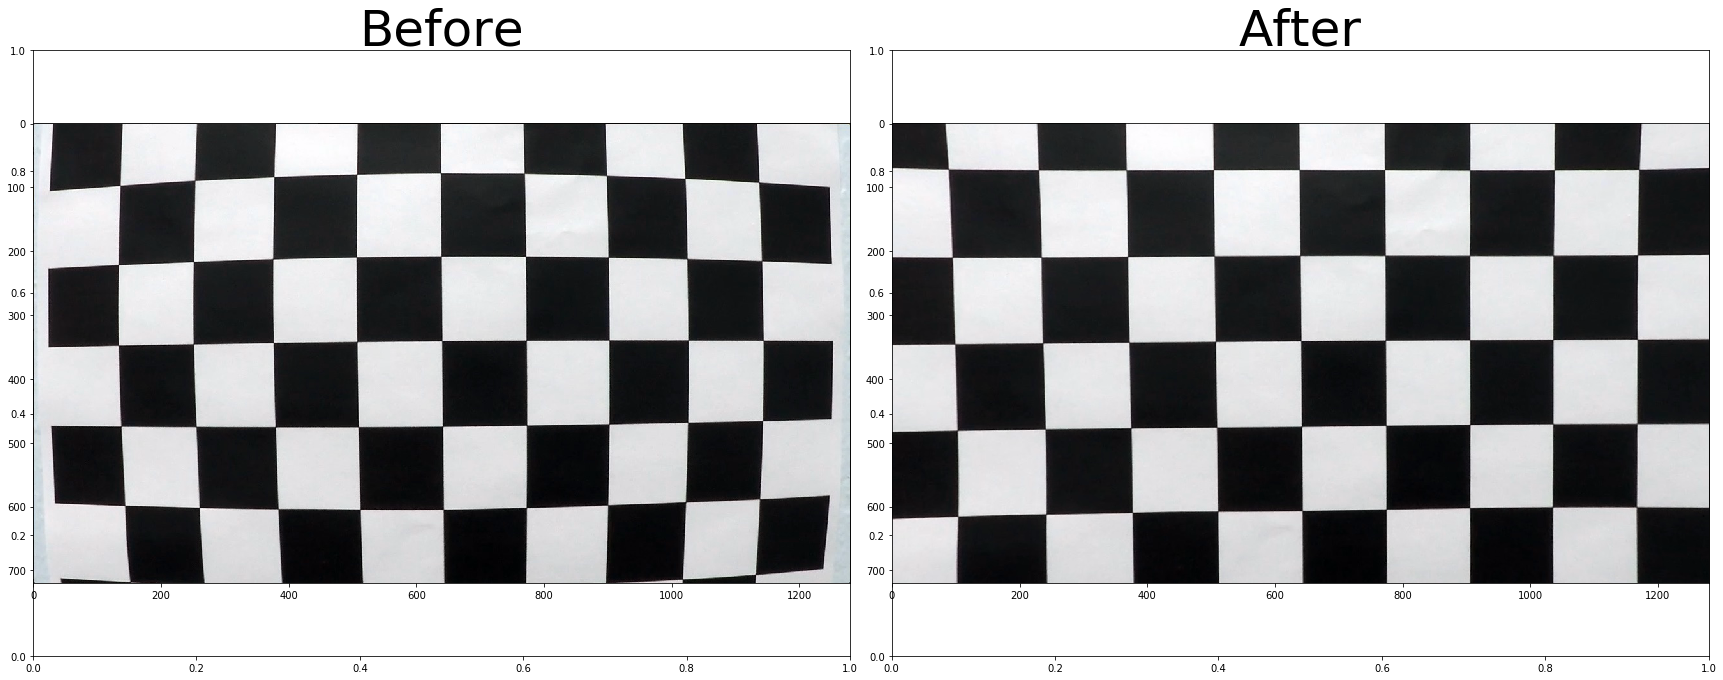

In [655]:
images = glob.glob('camera_cal/calibration*.jpg')
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
img = cv2.imread(images[0])
fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=50)
plt.imshow(img)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
fig.add_subplot(1,2,2)
ax2.set_title('After', fontsize=50)
plt.imshow(dst)

## Calibrate Camera & Undistort -- on driving images

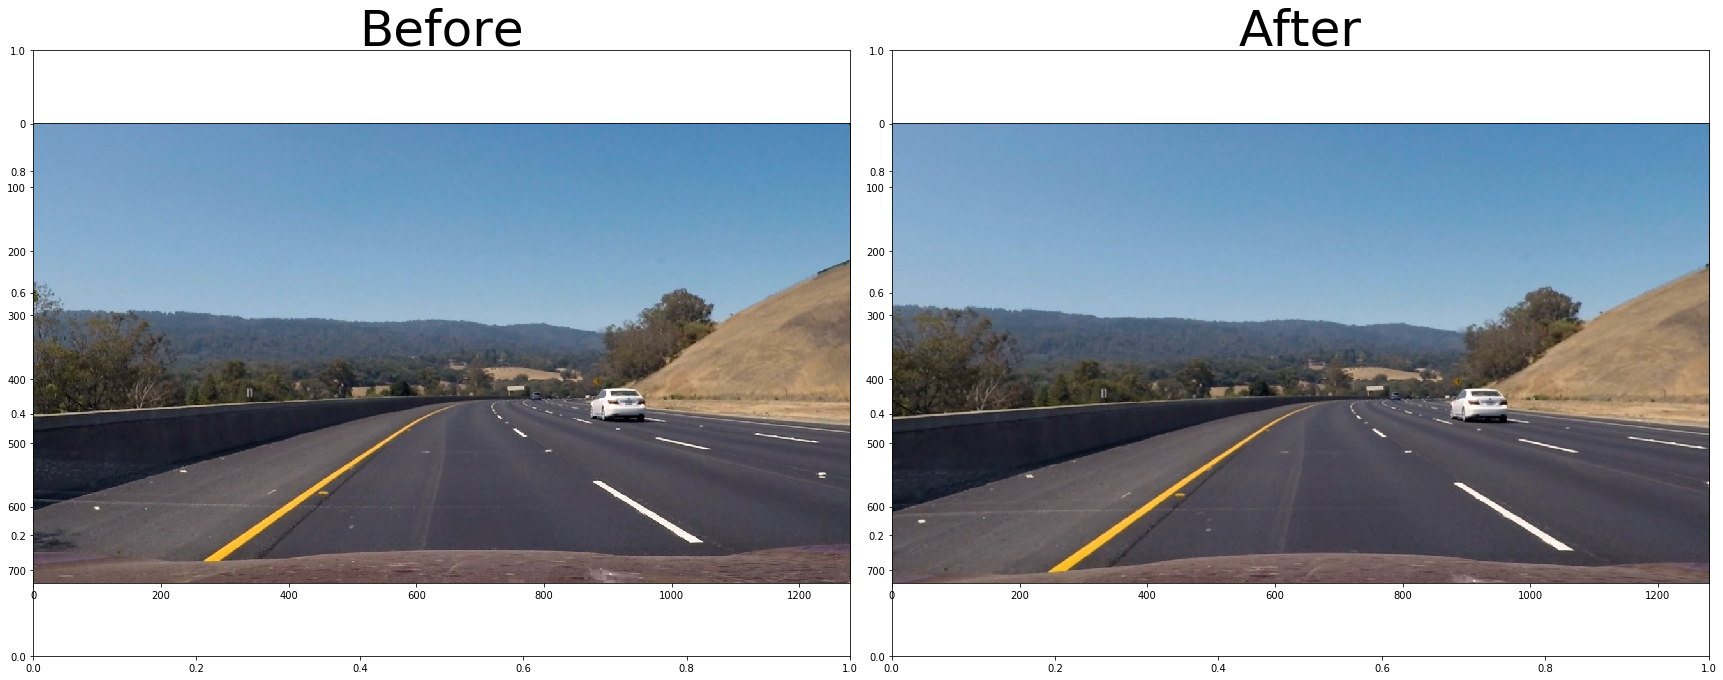

In [656]:
images = glob.glob('test_images/test3.jpg')
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
img = plt.imread(images[0])
fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=50)
plt.imshow(img)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
fig.add_subplot(1,2,2)
ax2.set_title('After', fontsize=50)
plt.imshow(dst)

## Binary Image

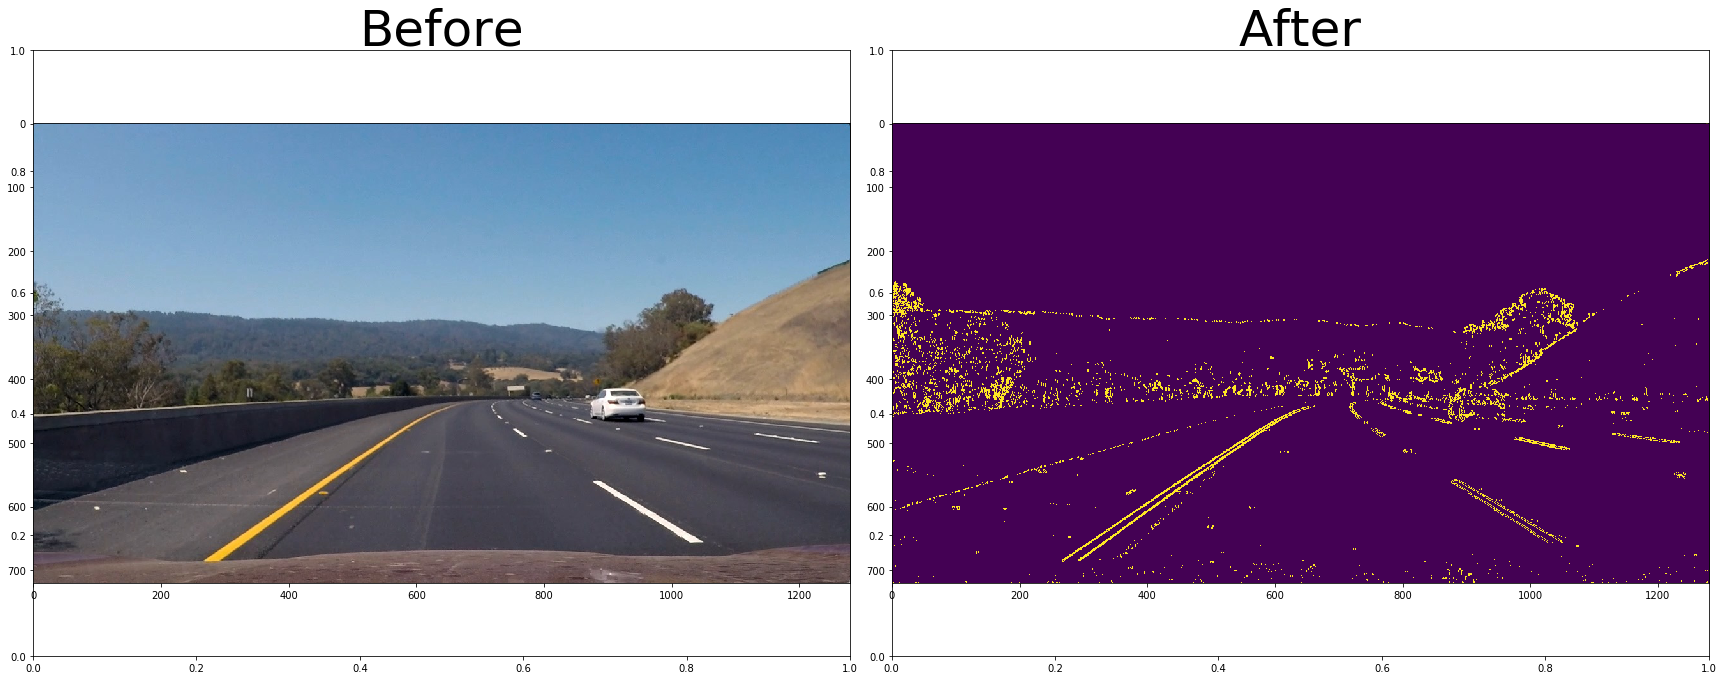

In [657]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

images = glob.glob('test_images/test3.jpg')
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
img = plt.imread(images[0])
fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=50)
plt.imshow(img)
dst = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
fig.add_subplot(1,2,2)
ax2.set_title('After', fontsize=50)
plt.imshow(dst)


## Magnitude of the Gradient

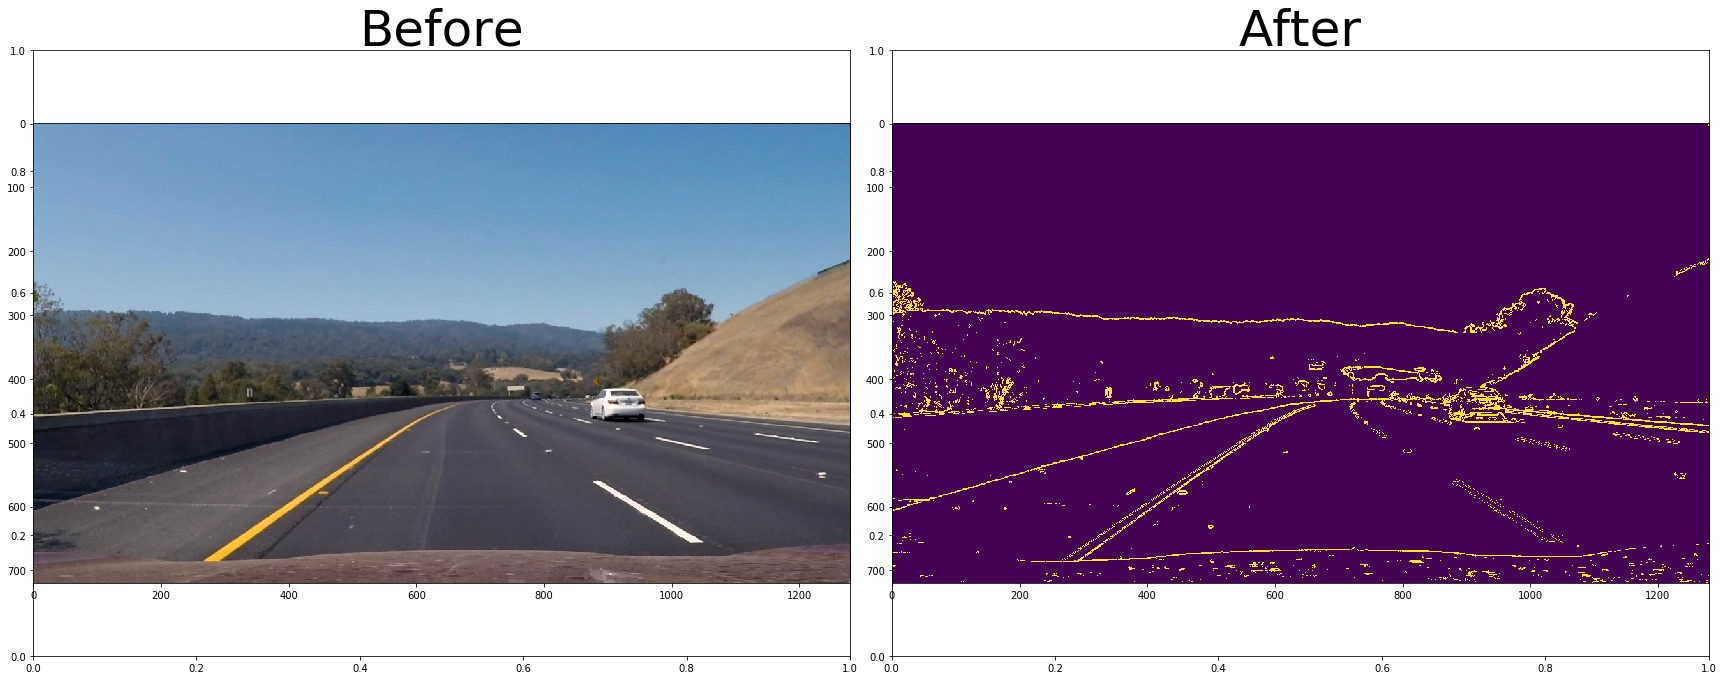

In [658]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

images = glob.glob('test_images/test3.jpg')
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
img = plt.imread(images[0])
fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=50)
plt.imshow(img)
dst = mag_thresh(img, sobel_kernel=1, mag_thresh=(30, 100))
fig.add_subplot(1,2,2)
ax2.set_title('After', fontsize=50)
plt.imshow(dst)

## Direction of the Gradient

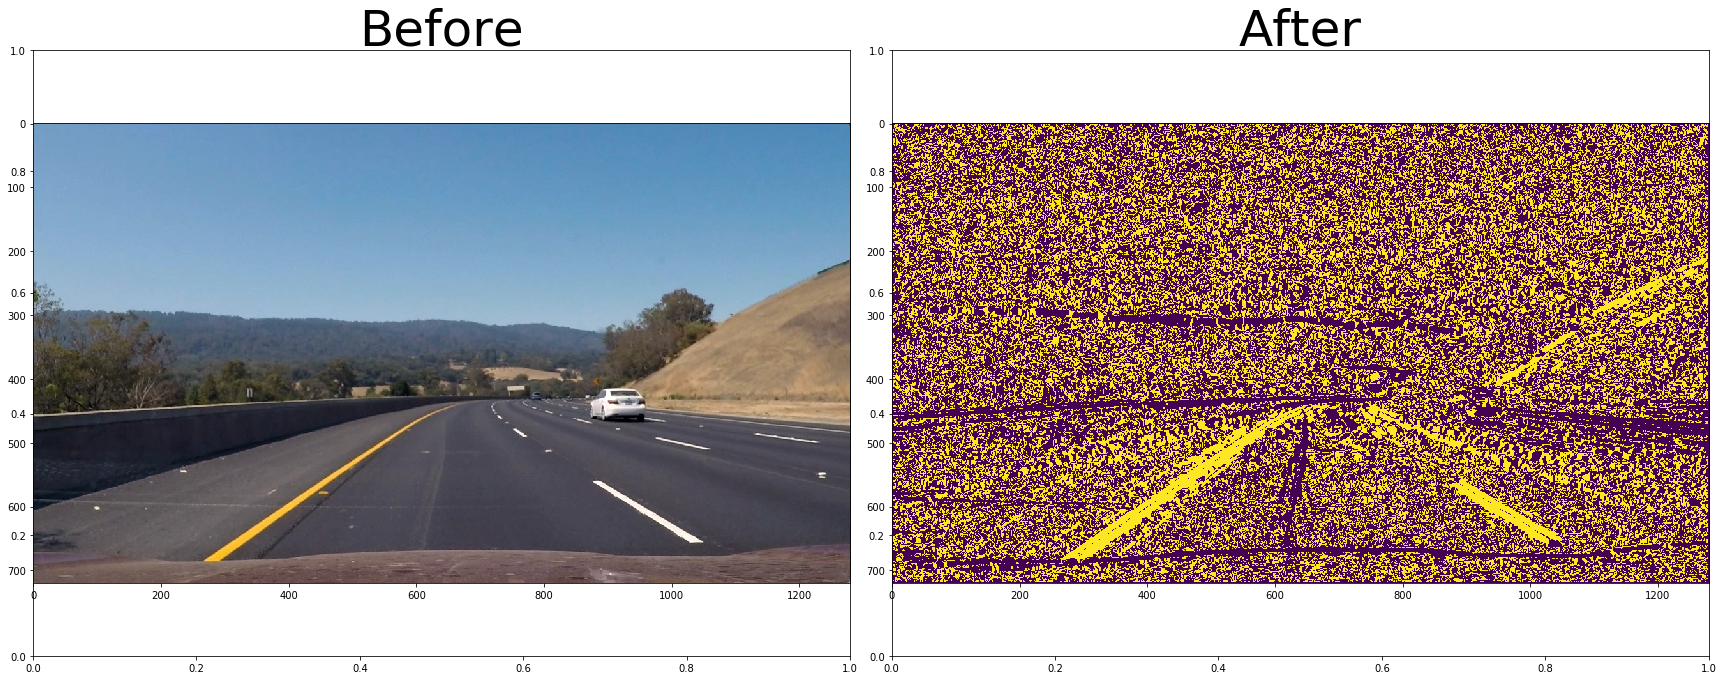

In [659]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

images = glob.glob('test_images/test3.jpg')
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
img = plt.imread(images[0])
fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=50)
plt.imshow(img)
dst = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
fig.add_subplot(1,2,2)
ax2.set_title('After', fontsize=50)
plt.imshow(dst)

## Color (HLS & HSV & LUV format) & gradient threshold

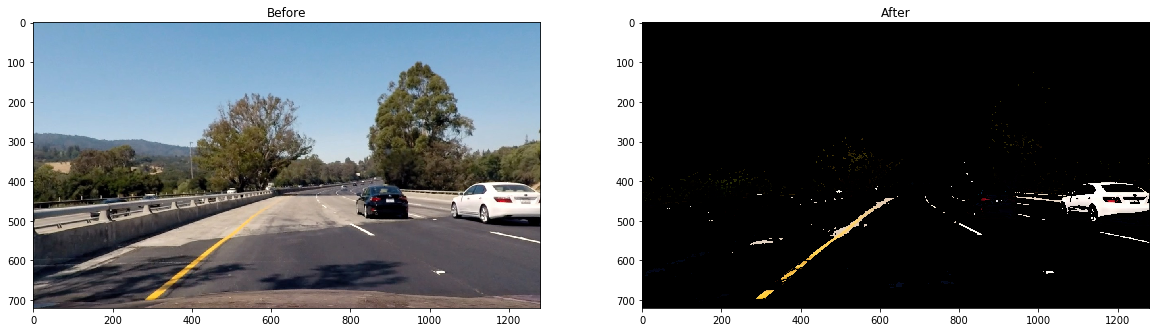

In [660]:
def hls(img, s_thresh, r_thresh):
    # Yellow Line filter
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # White Line filter
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    mask = np.zeros_like(s_channel)
    mask[(s_binary == 1) | (r_binary == 1)] = 1
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

img = plt.imread('test_images/test4.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
    
lower_yellow = np.array([10, 100 ,90])
upper_yellow = np.array([22, 220, 255])
lower_white = np.array([0, 0, 180])
upper_white = np.array([180, 25, 255])
mask, hls_res = hls(img, s_thresh=(170, 255), r_thresh=(220, 255))
    
# color_b = hsv_thresh(img)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Before')
ax1.imshow(img)

ax2.set_title('After')
ax2.imshow(hls_res, cmap='gray')


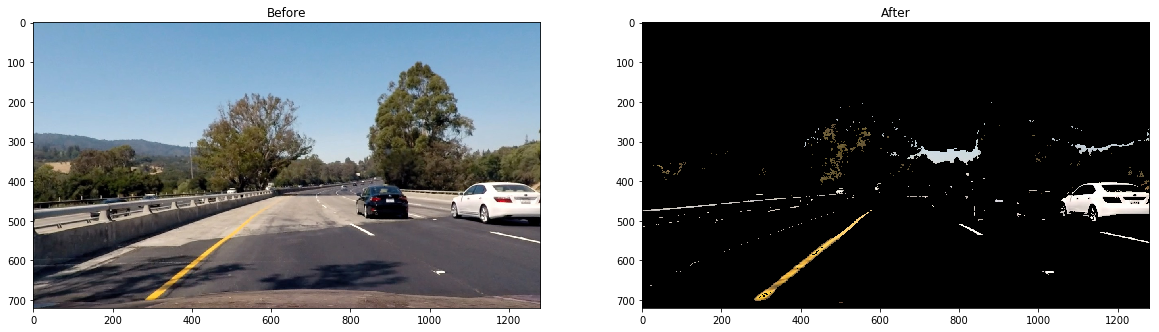

In [661]:
def hsv(img, l_yellow, h_yellow, l_white, h_white):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, l_yellow, h_yellow)
    white = cv2.inRange(hsv, l_white, h_white)
    mask = cv2.bitwise_or(yellow, white)
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

img = plt.imread('test_images/test4.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
    
lower_yellow = np.array([10, 100 ,90])
upper_yellow = np.array([22, 220, 255])
lower_white = np.array([0, 0, 180])
upper_white = np.array([180, 25, 255])
mask, hsv_res = hsv(img, lower_yellow, upper_yellow, lower_white, upper_white)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Before')
ax1.imshow(img)

ax2.set_title('After')
ax2.imshow(hsv_res, cmap='gray')

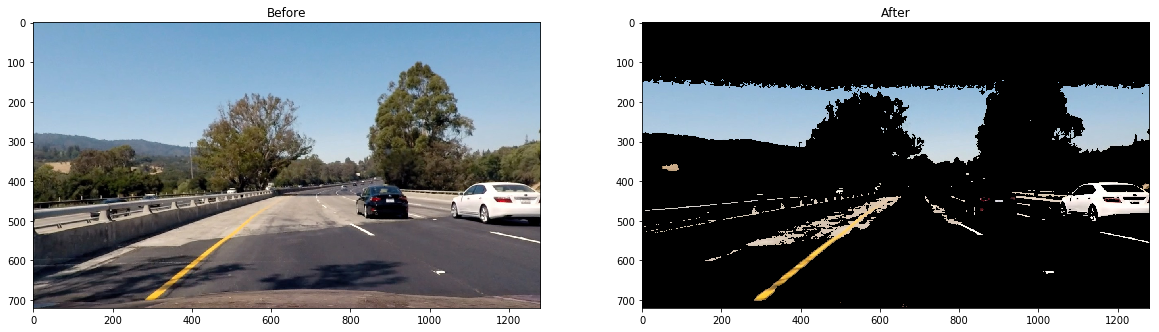

In [662]:
def lab(img, l_yellow, h_yellow, l_white, h_white):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    yellow = cv2.inRange(lab, l_yellow, h_yellow)
    white = cv2.inRange(lab, l_white, h_white)
    mask = cv2.bitwise_or(yellow, white)
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

lower_yellow = np.array([0, 0 , 80])
upper_yellow = np.array([255, 255, 110])
lower_white = np.array([196, 0, 0])
upper_white = np.array([255, 255, 255])
mask, lab_res = lab(img, lower_yellow, upper_yellow, lower_white, upper_white)

img = plt.imread('test_images/test4.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
    
lower_yellow = np.array([10, 100 ,90])
upper_yellow = np.array([22, 220, 255])
lower_white = np.array([0, 0, 180])
upper_white = np.array([180, 25, 255])
mask, hsv_res = hsv(img, lower_yellow, upper_yellow, lower_white, upper_white)
    
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Before')
ax1.imshow(img)

ax2.set_title('After')
ax2.imshow(lab_res, cmap='gray')

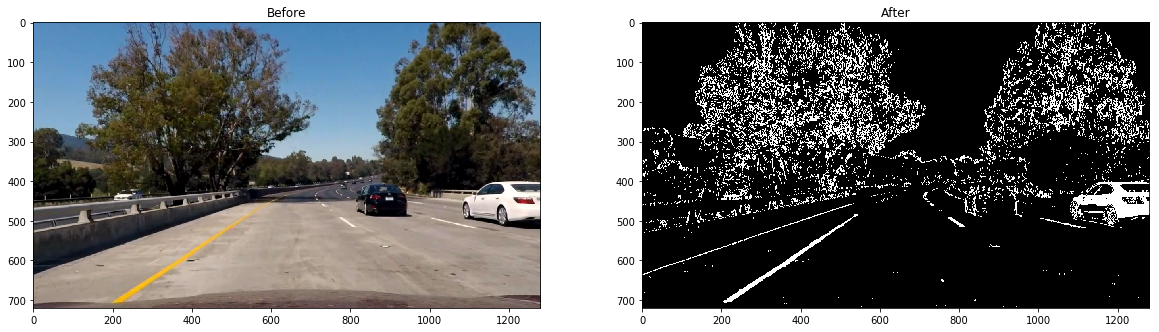

In [663]:
def combined(img):
    result = np.zeros_like(img)
    w = np.int(img.shape[1]/2)
    h = np.int(img.shape[0]/2)
    
    mask, hls_res = hls(img, s_thresh=(170, 255), r_thresh=(220, 255))
    
    lower_yellow = np.array([10, 100 ,90])
    upper_yellow = np.array([22, 220, 255])
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 25, 255])
    mask, hsv_res = hsv(img, lower_yellow, upper_yellow, lower_white, upper_white)
    
    lower_yellow = np.array([0, 0 , 80])
    upper_yellow = np.array([255, 255, 110])
    lower_white = np.array([196, 0, 0])
    upper_white = np.array([255, 255, 255])
    mask, lab_res = lab(img, lower_yellow, upper_yellow, lower_white, upper_white)


    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)  
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    
    # Combine image
    grad = np.zeros_like(gradx)
    grad[(hls_res[:,:,1] > 20) | (hsv_res[:,:,2] == 255) | (lab_res[:,:,1] == 255) | (gradx == 1)]=1
    return grad


img = plt.imread('test/frame1013.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
color_b = combined(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Before')
ax1.imshow(img)

ax2.set_title('After')
ax2.imshow(color_b, cmap='gray')

## Perspective Transformation 

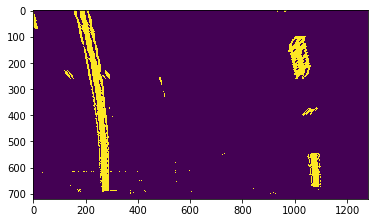

In [664]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    leftupperpoint  = [568,470]
    rightupperpoint = [717,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

# def get_Minv(img):
#     img_size = (img.shape[1], img.shape[0])
#     leftupperpoint  = [568,470]
#     rightupperpoint = [717,470]
#     leftlowerpoint  = [260,680]
#     rightlowerpoint = [1043,680]

#     src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
#     dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])
#     M = cv2.getPerspectiveTransform(src, dst)
#     Minv = cv2.getPerspectiveTransform(dst, src)
#     warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
#     return Minv
plt.clf()
img = plt.imread('test/frame1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
img = combined(img)
dst,minv = warp(img)
plt.imshow(dst)

# Histogram of the lane lines

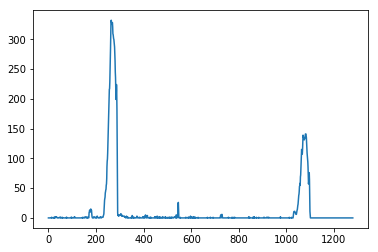

In [665]:
histogram = np.sum(dst[int(img.shape[0]/2):,:], axis=0)
plt.plot(histogram)

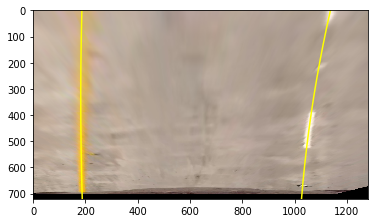

In [683]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
def fit_line(combined_binary):
    binary_warped,minv = warp(combined_binary)
#     plt.imshow(combined_binary)
#     plt.imshow(binary_warped[int(binary_warped.shape[0]/2):,:])
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    curv_pickle = {}
    curv_pickle["leftx"] = leftx
    curv_pickle["rightx"] = rightx
    curv_pickle["lefty"] = lefty
    curv_pickle["righty"] = righty
    curv_pickle["left_fit"] = left_fitx
    curv_pickle["right_fit"] = right_fitx
    
    return left_fitx, right_fitx, ploty, curv_pickle

img = plt.imread('test/frame1016.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
combined_binary = combined(img)
left_fx, right_fx, plot_y, _ = fit_line(combined_binary)
    
# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img)
plt.plot(left_fx, plot_y, color='yellow')
plt.plot(right_fx, plot_y, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
warped,_ = warp(img)
plt.imshow(warped)

In [684]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

215.537830753
1056.80590264


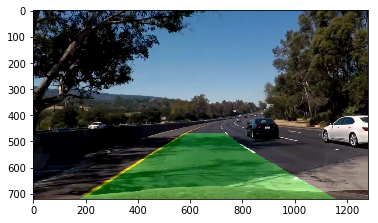

In [686]:
# Create an image to draw the lines on
img = plt.imread('test/frame1037.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
combined_binary = combined(undist)
warped, minv = warp(combined_binary)
# Minv = get_Minv(warped)
# undist = cv2.undistort(img, mtx, dist, None, mtx)
# plt.imshow(warped)

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
left_x, right_x, plot_y, _ = fit_line(combined_binary)
print(np.mean(left_x))
print(np.mean(right_x))
pts_left = np.array([np.transpose(np.vstack([left_x, plot_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, plot_y])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
# plt.imshow(undist)
plt.imshow(result, cmap='gray')

# Pipline

In [388]:
# Queue for smoothing the curve
class Queue:
    """
    Define a queue class for smoothing the slope and bias of the lane line.
    Smoothing is necessary for this task. 
    """
    def __init__(self):
        self.items = []

    def isEmpty(self):
        return self.items == []
    
    def Empty(self):
        while self.isEmpty() == False:
            self.items.get()
        return self.items
    
    def put(self, item):
        self.items.insert(0,item)
        
    def avg(self):
        return np.mean(self.items, axis=0)

    def get(self):
        return self.items.pop()

    def size(self):
        return len(self.items)

In [591]:
def calculate_curvature(leftx, rightx, lefty, righty):
    '''Calculate the radius of curvature in meters'''
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    #y_eval = np.max(ploty)
    y_eval = 719
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return left_curverad, right_curverad

def calculate_offset(undist, left_fit, right_fit):
    '''Calculate the offset of the lane center from the center of the image'''
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = undist.shape[0]-1 # height
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    offset = (left_fitx+right_fitx)/2 - undist.shape[1]/2 # width
    offset = xm_per_pix*offset
    
    return offset

array([[[ 97, 153, 200],
        [ 97, 153, 200],
        [ 97, 153, 200],
        ..., 
        [ 88, 150, 197],
        [ 87, 149, 196],
        [ 85, 147, 194]],

       [[ 98, 154, 201],
        [ 97, 153, 200],
        [ 97, 153, 200],
        ..., 
        [ 87, 149, 196],
        [ 86, 148, 195],
        [ 85, 147, 194]],

       [[ 98, 154, 201],
        [ 98, 154, 201],
        [ 98, 154, 201],
        ..., 
        [ 87, 149, 196],
        [ 86, 148, 195],
        [ 86, 148, 195]],

       ..., 
       [[103,  89, 104],
        [104,  90, 104],
        [105,  91, 105],
        ..., 
        [126, 107, 100],
        [127, 108, 101],
        [123, 104,  97]],

       [[105,  91, 103],
        [106,  92, 104],
        [107,  92, 105],
        ..., 
        [125, 106,  99],
        [125, 106,  99],
        [123, 104,  97]],

       [[110,  94, 105],
        [110,  94, 105],
        [110,  94, 104],
        ..., 
        [126, 107, 100],
        [126, 107, 100],
        [125, 107,

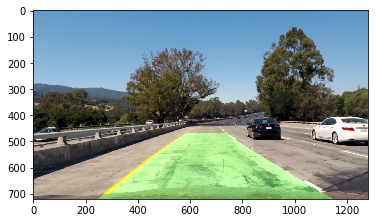

In [616]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
global left 
left = Queue()
global right 
right = Queue()

global left_pre_avg 
left_pre_avg = 0
global right_pre_avg
right_pre_avg = 0
def process_frame(img):
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    combined_binary = combined(undist)
    warped, minv = warp(combined_binary)

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    left_fitx, right_fitx, plot_y, curve_pickle = fit_line(combined_binary)

    # Smooth the curve line
    global left_pre_avg
    if left_pre_avg == 0:
        left_pre_avg = np.mean(left_fitx)
        right_pre_avg = np.mean(right_fitx)
    if left.size()<=10:
        left.put(left_fitx)
        right.put(right_fitx)
    elif abs(np.mean(left_fitx)-left_pre_avg)<10:
        left.get()
        right.get()
        left.put(left_fitx)
        right.put(right_fitx)
        
    left_pre_avg = np.mean(left_fitx)
    right_pre_avg = np.mean(right_fitx)
    
    left_x = left.avg()
    right_x = right.avg()

    pts_left = np.array([np.transpose(np.vstack([left_x, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, plot_y])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

#     left_fit = curve_pickle["left_fit"]
#     right_fit = curve_pickle["right_fit"]
#     leftx = curve_pickle["leftx"]
#     lefty = curve_pickle["lefty"]
#     rightx = curve_pickle["rightx"]
#     righty = curve_pickle["righty"]

#     # Calculate curvature
#     # Assume first frame can be detected both lanes and curvatures 
#     left_curverad, right_curverad = calculate_curvature(leftx, rightx, lefty, righty)
    
#     vehicle_offset = calculate_offset(undist, left_fit, right_fit)
    
#     # Anotate curvature values 
#     ave_curvature = (left_curverad + right_curverad)/2
#     ave_text = 'Radius of average curvature: %.2f m'%ave_curvature
#     cv2.putText(result, ave_text,(50,50), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    
#     # Anotate vehicle offset from the lane center
#     if(vehicle_offset>0):
#         offset_text = 'Vehicle right offset from lane center: {:.2f} m'.format(vehicle_offset)
#     else:
#         offset_text = 'Vehicle left offset from the lane center: {:.2f} m'.format(-vehicle_offset)
#     cv2.putText(result, offset_text,(50,80), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    plt.imshow(result)
    return result
    
image = plt.imread('test_images/test1.jpg')
process_frame(image)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [05:54<00:00,  3.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 6min 32s, sys: 1min 12s, total: 7min 45s
Wall time: 5min 55s


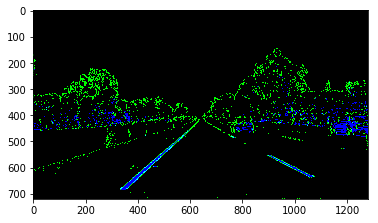

In [572]:
project_video_output = 'project.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(project_video_output, audio=False)